In [100]:
import pandas as pd
import numpy as np
import sys, os
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from textblob import TextBlob
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import warnings
import logging
import string
nltk.download('reuters') # Downloading corpus
nltk.download('stopwords') # Downloading stopwords
nltk.download('punkt') # Downloading tokenizer
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab Notebooks/Automatic_Ticket_Assignment_NLP_Project"
%ls

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/Automatic_Ticket_Assignment_NLP_Project
input_data.xlsx  NLP_Automatic_Ticket_Assignment_Capstone_Project_Soundar.ipynb


## Read ticket data file as data frame

In [18]:
project_path = 'content/drive/MyDrive/Colab Notebooks/Automatic_Ticket_Assignment_NLP_Project/'
ticket_df = pd.read_excel('input_data.xlsx')  
ticket_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


# Show head of the data

In [19]:
ticket_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


# Shape of the data

In [20]:
ticket_df.shape

(8500, 4)

## Describe data

In [21]:
ticket_df.describe()

,Short description,Description,Caller,Assignment group
count,8492,8499,8500,8500
unique,7481,7817,2950,74
top,password reset,the,bpctwhsn kzqsbmtp,GRP_0
freq,38,56,810,3976


# Find any Null values in the data 

In [22]:
ticket_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [23]:
ticket_df = ticket_df.fillna("")

In [24]:
ticket_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

## Find any duplicate rows in the dataframe

In [25]:
duplicate = ticket_df[ticket_df.duplicated()]
duplicate.shape

(83, 4)

In [26]:
ticket_df.drop_duplicates(inplace=True)
ticket_df.shape

(8417, 4)

## Analyze the distribution of Assignment Group

In [27]:
targetClassCnt=ticket_df['Assignment group'].value_counts()
targetClassCnt.head()

GRP_0     3934
GRP_8      645
GRP_24     285
GRP_12     257
GRP_9      252
Name: Assignment group, dtype: int64

In [28]:
targetClassCnt.describe()

count      74.000000
mean      113.743243
std       460.731077
min         1.000000
25%         5.250000
50%        26.000000
75%        81.000000
max      3934.000000
Name: Assignment group, dtype: float64

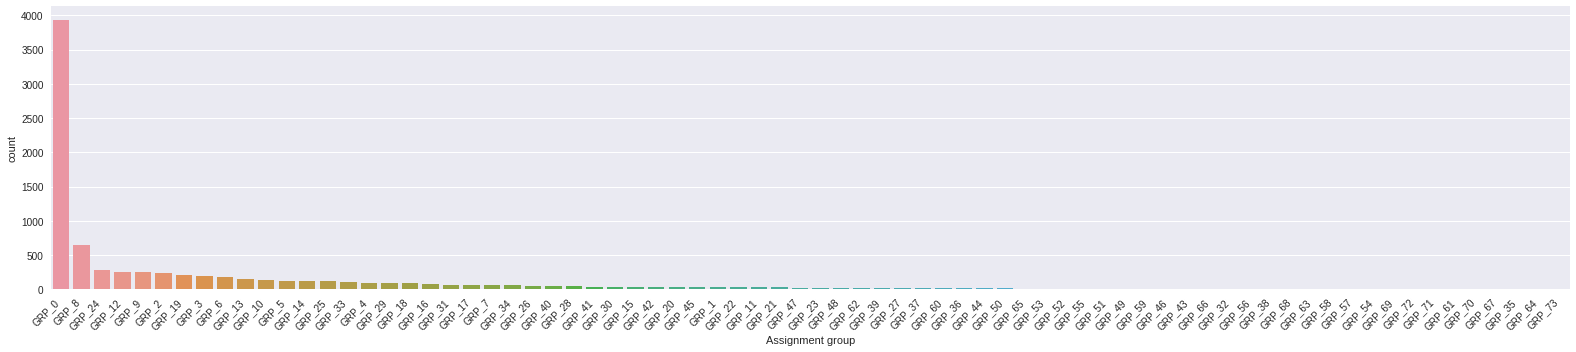

In [29]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups

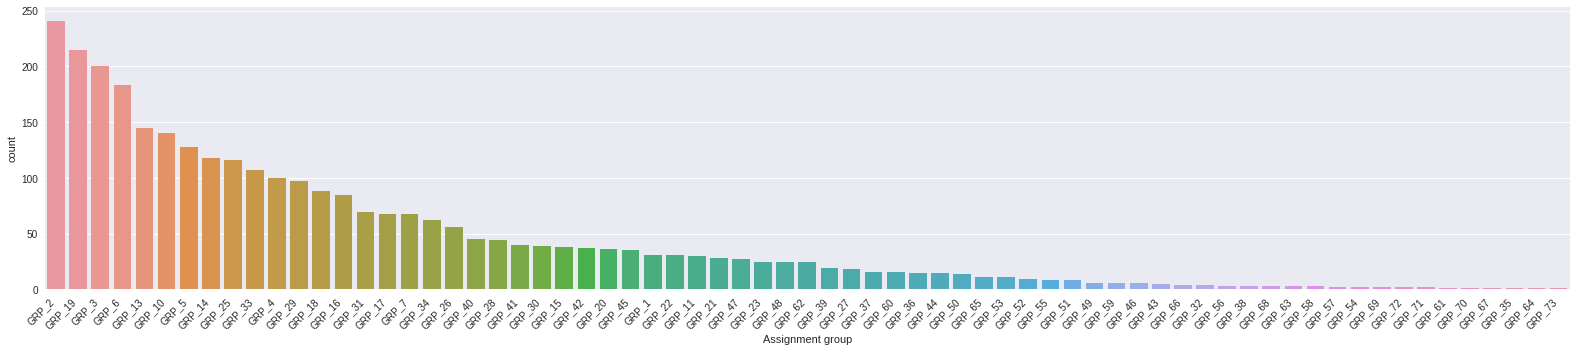

In [30]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[5:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of all assignment groups excluding top 5

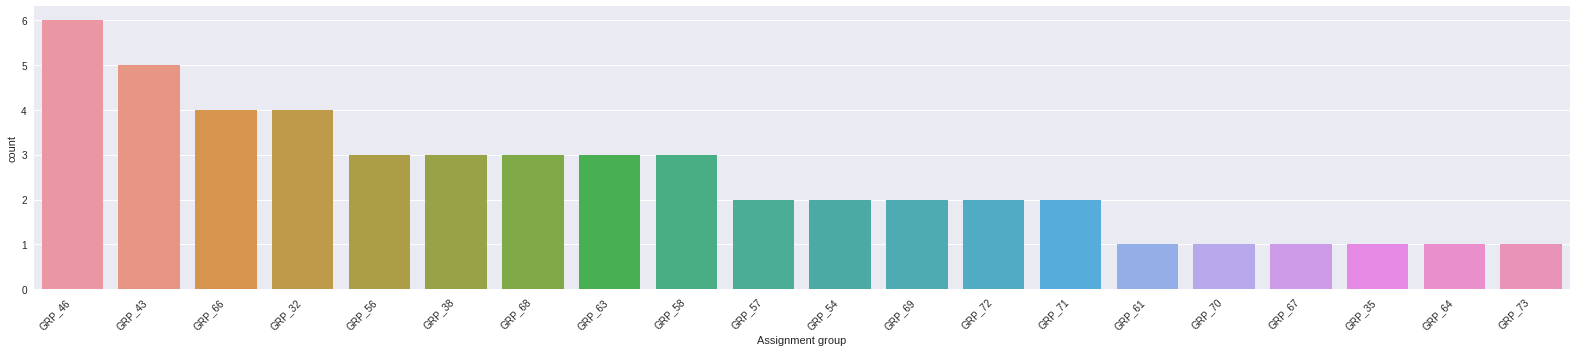

In [31]:
descending_order = ticket_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=ticket_df,order=descending_order[-20:])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above plot shows the distribution of bottom most 20 assignment groups .

As there are groups with just one ticket, we can club together all groups with less than 3 records into one group and analyze the data

In [32]:
asnGroupBy = ticket_df.groupby(['Assignment group'])
others=[]
for grp in ticket_df['Assignment group'].unique():
  if(asnGroupBy.get_group(grp).shape[0]<5):
    others.append(grp)
print('Found {} groups which have under 5 samples'.format(len(others)))
ticket_df['Assignment group']=ticket_df['Assignment group'].apply(lambda x : 'OTHERS' if x in others  else x)

ticket_df['Assignment group'].unique()

Found 18 groups which have under 5 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'OTHERS', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45',
       'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50', 'GRP_51',
       'GRP_52', 'GRP_53', 'GRP_55', 'GRP_59', 'GRP_60', 'GRP_62',
       'GRP_65'], dtype=object)

## Analyse the distribution of Callers

In [33]:
callers = ticket_df['Caller'].unique() 
callers.shape

(2950,)

In [34]:
callersCntDF = ticket_df['Caller'].value_counts()
print(callersCntDF.describe())
callersCntDF.head()

count    2950.000000
mean        2.853220
std        15.416578
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       788.000000
Name: Caller, dtype: float64


bpctwhsn kzqsbmtp    788
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    128
rbozivdq gmlhrtvp     72
rkupnshb gsmzfojw     71
Name: Caller, dtype: int64

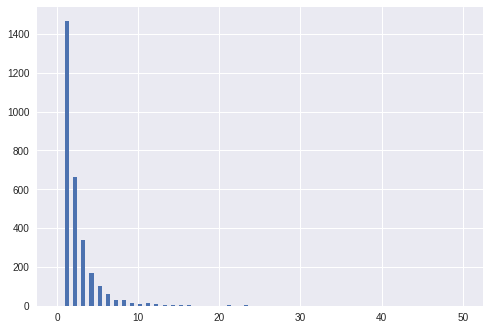

In [35]:
callersCntDF.hist(bins=100,range=(0,50))

Observation: The number of callers who reported more than 10 tickets is very less. And most of the callers have reported 1-2 tickets

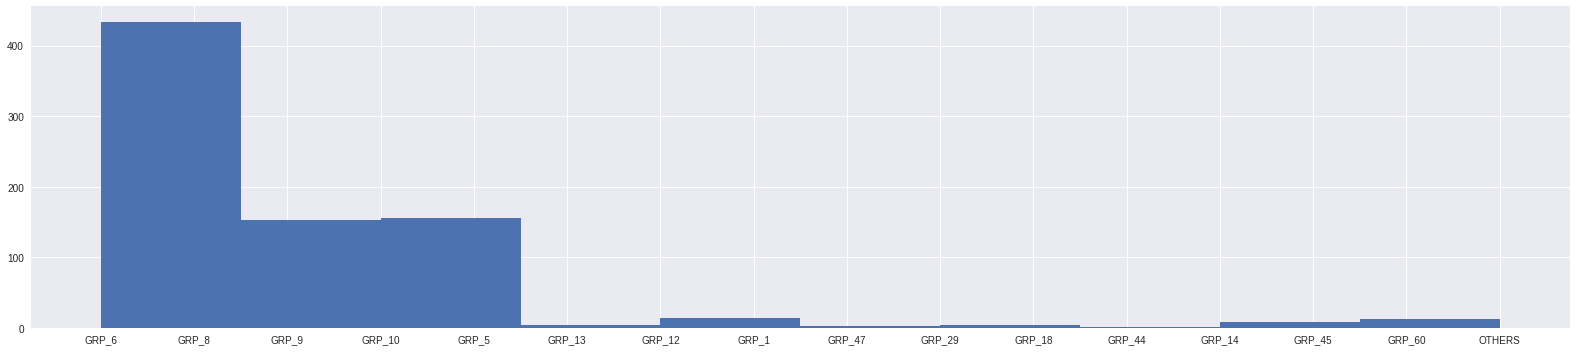

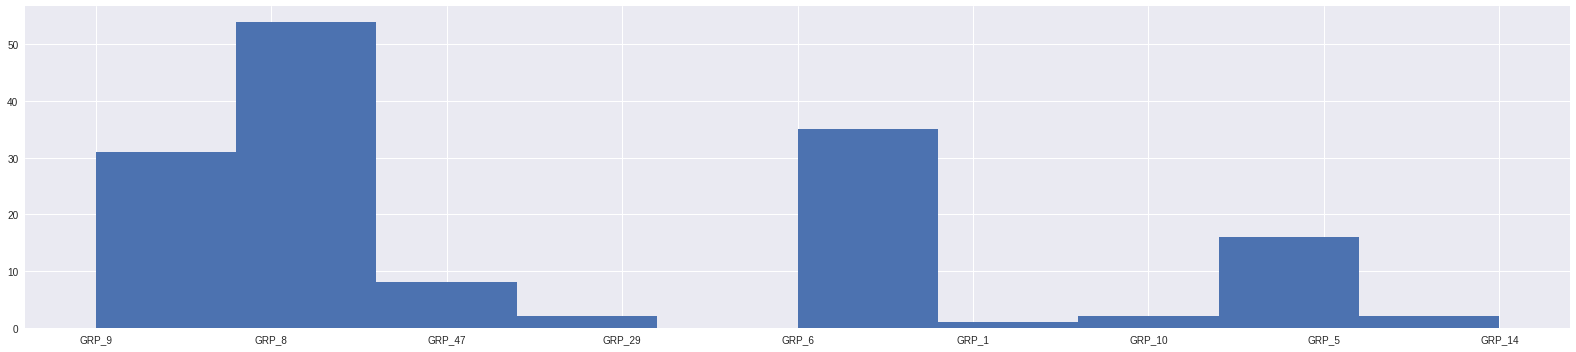

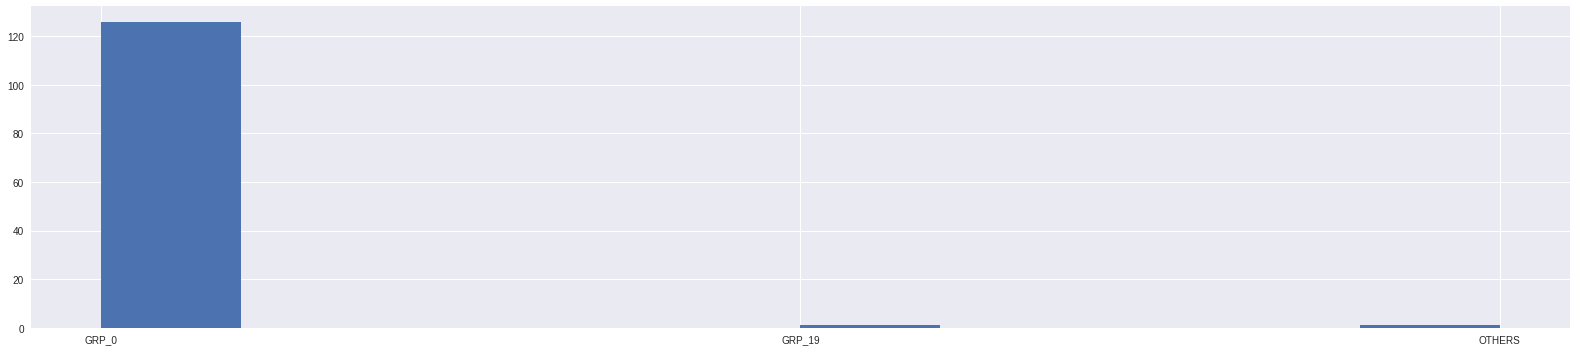

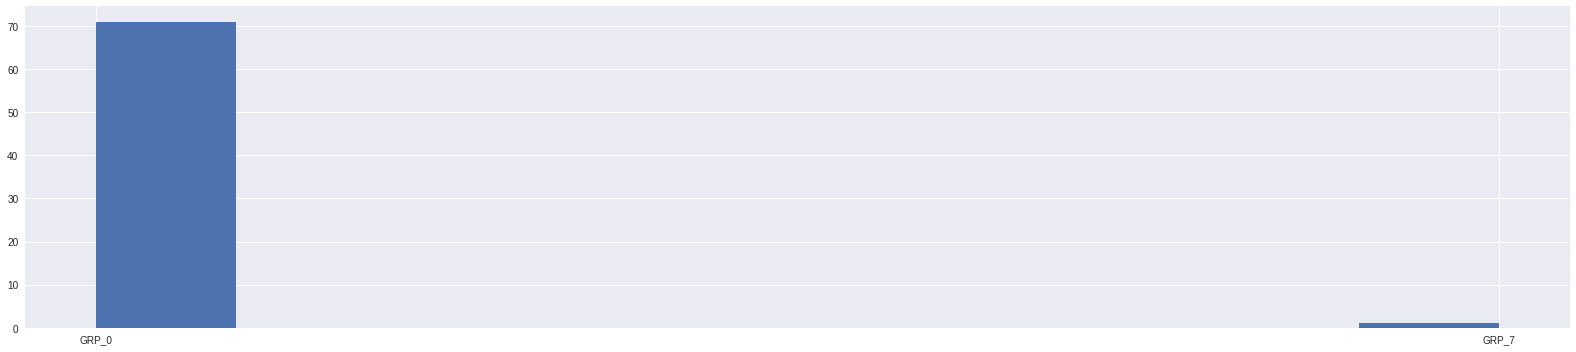

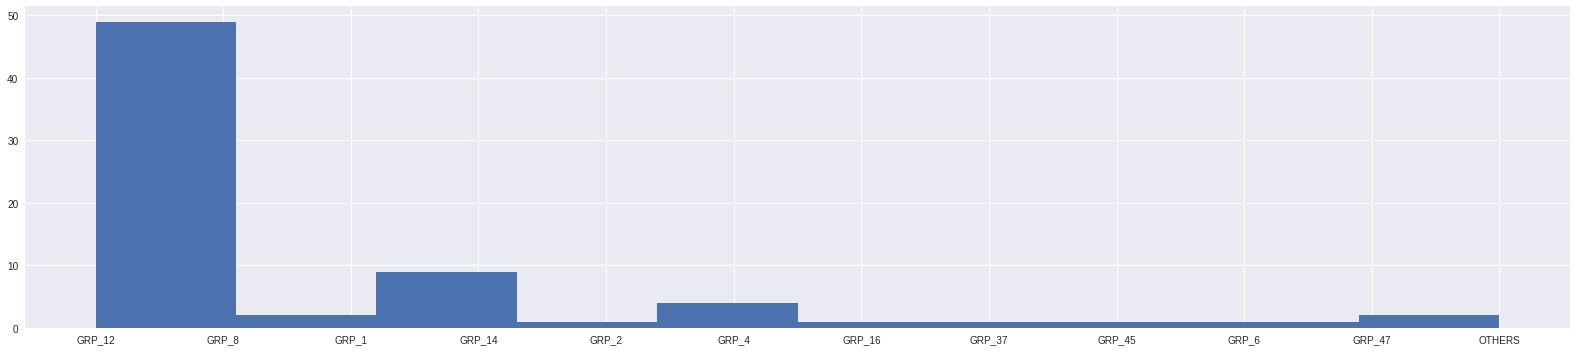

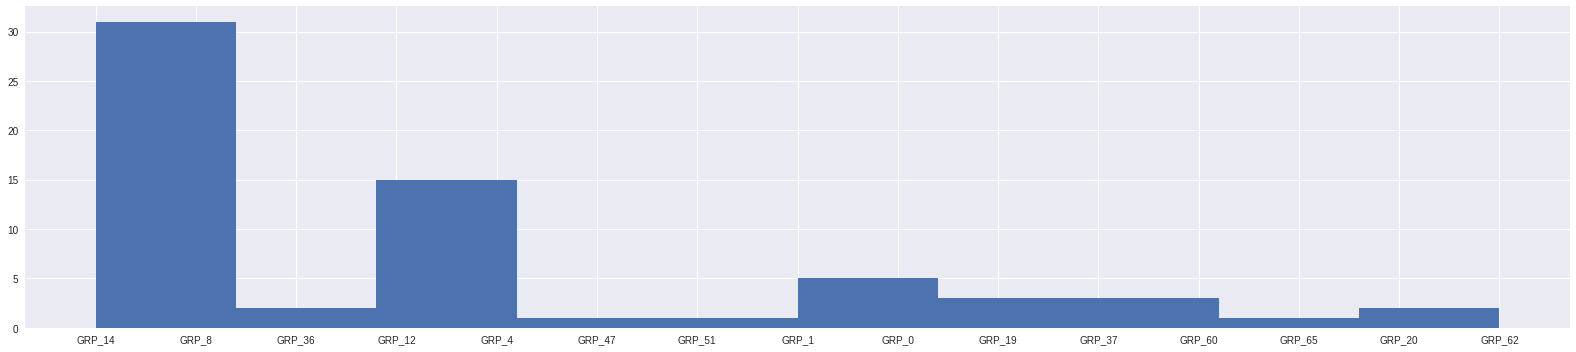

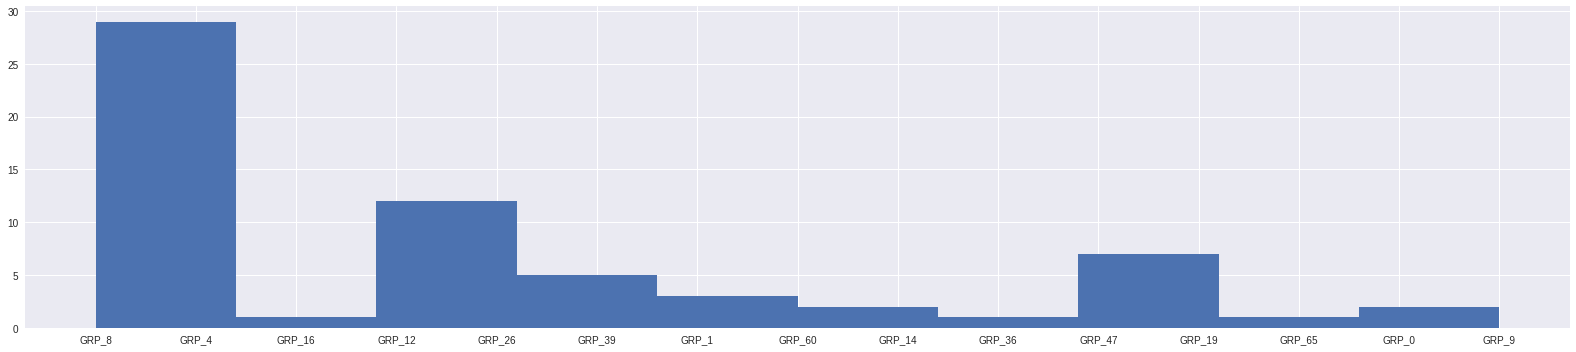

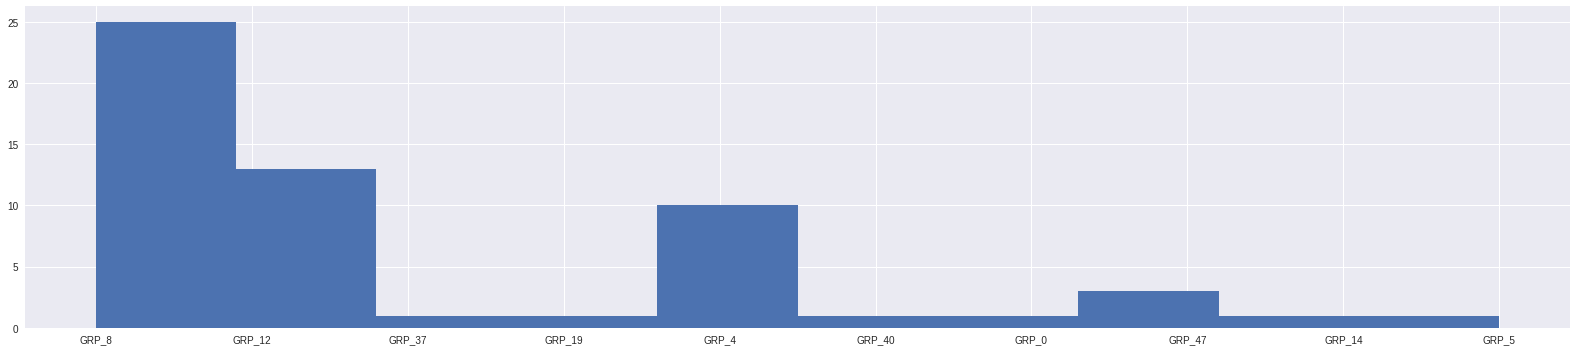

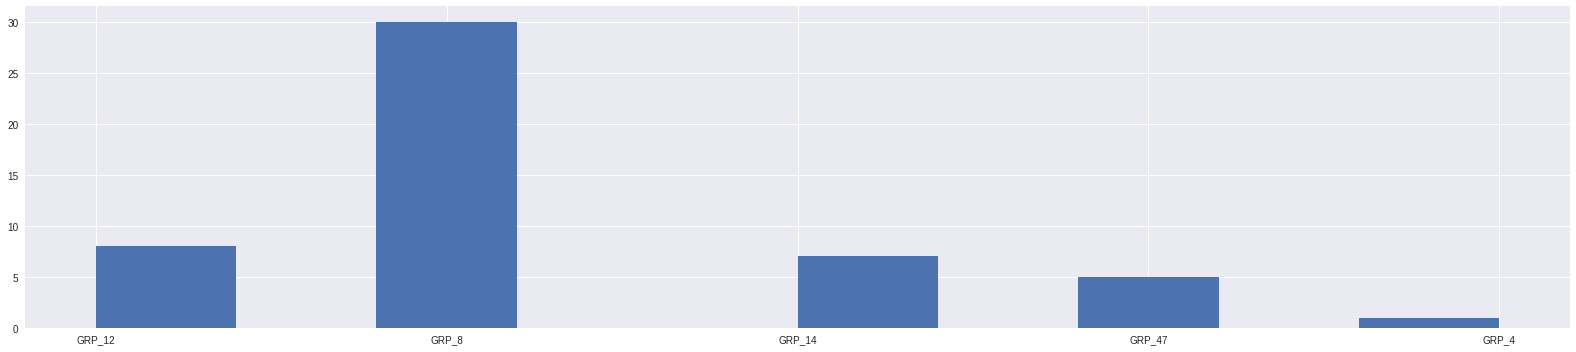

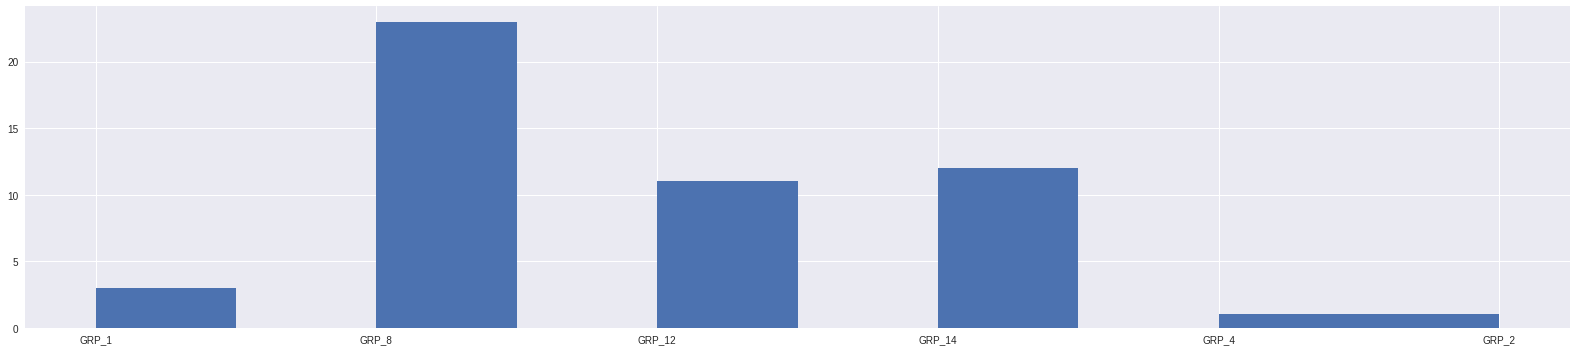

In [36]:
# look at distribution of Assignment Group for 10 most frequent callers
top_10_callers = callersCntDF.index[:10]
for caller in top_10_callers:
  assignment_groups = ticket_df[ticket_df['Caller']==caller]['Assignment group']
  plt.figure(figsize=(22,5))
  assignment_groups.hist()
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.tight_layout()
  plt.show()

Observation: The most frequent caller has raised tickets for a variety of Assignment groups. Therefore, we will consider caller name in our models

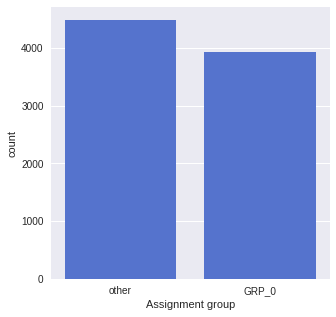

In [37]:
ticket_df_grp0 = ticket_df.copy()
ticket_df_grp0['Assignment group']=ticket_df_grp0['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = ticket_df_grp0['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=ticket_df_grp0, color='royalblue',order=descending_order)

Observation: The above plot shows the distribution of samples of GRP_0 vs all other groups combined. We need to fix the imbalance in the data using data augmentation techniques

In [38]:
ticket_df['sd_len'] = ticket_df['Short description'].astype(str).apply(len)
ticket_df['sd_word_count'] = ticket_df['Short description'].apply(lambda x: len(str(x).split()))
ticket_df['ld_len'] = ticket_df['Description'].astype(str).apply(len)
ticket_df['ld_word_count'] = ticket_df['Description'].apply(lambda x: len(str(x).split()))

In [39]:
ticket_df.head()

,Short description,Description,Caller,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,11,2,206,33
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,7,1,194,25
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,18,5,87,11
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,29,5,29,5
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,12,2,12,2


In [40]:
#sd_lengths = ticket_df['Short description'].map(len)
#sd_lengths.describe()
ticket_df['sd_len'].describe()

count    8417.000000
mean       47.253059
std        27.068818
min         0.000000
25%        26.000000
50%        41.000000
75%        62.000000
max       159.000000
Name: sd_len, dtype: float64

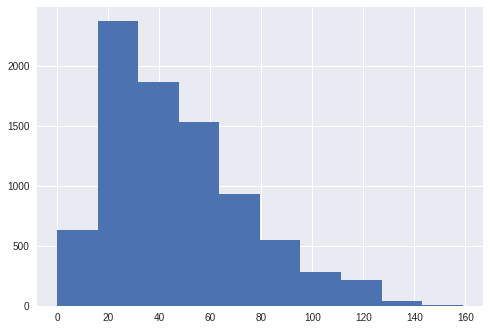

In [41]:
# sd_lengths.hist()
ticket_df['sd_len'].hist()

In [42]:
#sd_lengths.value_counts()[-20:]
ticket_df['sd_len'].value_counts()[-20:]

131    3
127    3
133    3
125    3
145    2
141    2
137    2
144    2
135    2
159    2
138    1
2      1
151    1
140    1
1      1
136    1
149    1
134    1
142    1
150    1
Name: sd_len, dtype: int64

Description: There are some single character short descriptions as well. However majority of the short description is not beyound 62 characters

In [43]:
# ld_lengths = ticket_df['Description'].map(len)
# ld_lengths.describe()

ticket_df['ld_len'].describe()

count     8417.000000
mean       205.498753
std        521.952353
min          0.000000
25%         42.000000
50%        106.000000
75%        203.000000
max      13001.000000
Name: ld_len, dtype: float64

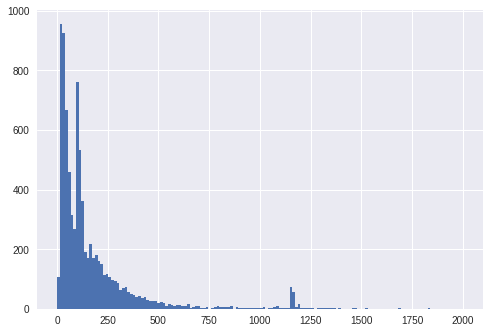

In [44]:
#ld_lengths.hist(bins=100,range=(0,2000))

ticket_df['ld_len'].hist(bins=150, range=(0,2000))

In [45]:
# ld_lengths.value_counts()[-20:]

ticket_df['ld_len'].value_counts()[-20:]

1347    1
1379    1
1387    1
1515    1
1659    1
1795    1
644     1
1839    1
4286    1
2293    1
388     1
468     1
516     1
532     1
564     1
588     1
596     1
612     1
628     1
0       1
Name: ld_len, dtype: int64

Description: There are some single character descriptions as well. However majority of the short description is not beyound 201 characters

In [46]:
ticket_df_temp =  ticket_df.copy()
ticket_df_temp['num_words'] = ticket_df['Description'].apply(lambda x : len(x.split()))
ticket_df_temp.describe()

,sd_len,sd_word_count,ld_len,ld_word_count,num_words
count,8417.000000,8417.000000,8417.000000,8417.000000,8417.000000
mean,47.253059,6.939290,205.498753,27.471902,27.471902
std,27.068818,4.133266,521.952353,65.319593,65.319593
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,4.000000,42.000000,6.000000,6.000000
50%,41.000000,6.000000,106.000000,11.000000,11.000000
75%,62.000000,9.000000,203.000000,28.000000,28.000000
max,159.000000,28.000000,13001.000000,1625.000000,1625.000000


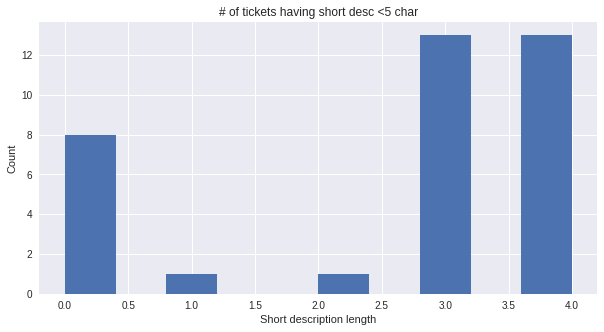

In [78]:
sd_len_FiveChar = ticket_df[ticket_df["sd_len"] < 5]
plt.xlabel('Short description length')
plt.ylabel('Count')
plt.title('# of tickets having short desc <5 char')
sd_len_FiveChar['sd_len'].hist(bins=10, figsize=(10,5))


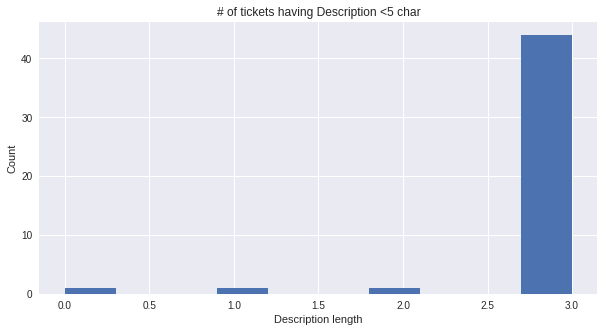

In [79]:
sd_len_FiveChar = ticket_df[ticket_df["ld_len"] < 5]
plt.xlabel('Description length')
plt.ylabel('Count')
plt.title('# of tickets having Description <5 char')
sd_len_FiveChar['ld_len'].hist(bins=10, figsize=(10,5))

Text(0.5, 1.0, 'Word distribution per bin')

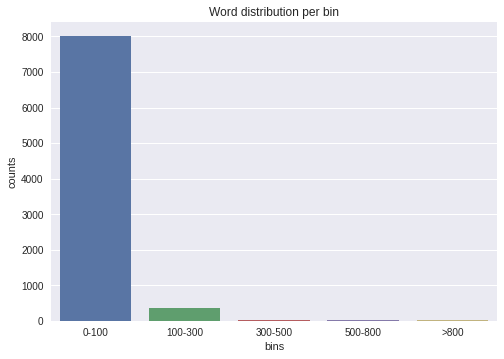

In [80]:
ticket_df_temp['bins']=pd.cut(ticket_df_temp.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = ticket_df_temp.groupby('bins').size().reset_index().rename(columns={0:'counts'})
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Observation: Most of the samples had word count within 100

In [81]:
class PreProcessing:
    lemmatizer=""
    stemmer =""
    tokenizer=""
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = LancasterStemmer()
        self.tokenizer = RegexpTokenizer(r'\w+')
    
    def data_clean(self, sentence):
      if pd.isnull(sentence):
        return sentence
      sentence= sentence.lower()
      sentence = ' '.join([w for w in sentence.split() if not self.is_valid_date(w)])
      sentence = re.sub(r"received from:",' ',sentence)
      sentence = re.sub(r"select the following link to view the disclaimer in an alternate language.",' ',sentence)
      sentence = re.sub(r"from:",' ',sentence)
      sentence = re.sub(r"to:",' ',sentence)
      sentence = re.sub(r"subject:",' ',sentence)
      sentence = re.sub(r"re:",' ',sentence)
      sentence = re.sub(r"fw:",' ',sentence)
      sentence = re.sub(r"sent:",' ',sentence)
      sentence = re.sub(r"ic:",' ',sentence)
      sentence = re.sub(r"cc:",' ',sentence)
      sentence = re.sub(r"bcc:",' ',sentence)
      #Remove email 
      sentence = re.sub(r'\S*@\S*\s?', '', sentence)
      # Remove underscores
      sentence = re.sub(r'\_',' ', sentence)

      # Remove new line characters 
      sentence = re.sub(r'\n',' ',sentence)
      # Remove hashtag while keeping hashtag sentence
      sentence = re.sub(r'#','', sentence)
      #& 
      sentence = re.sub(r'&;?', 'and',sentence)
      # Remove HTML special entities (e.g. &amp;)
      sentence = re.sub(r'\&\w*;', '', sentence)
      # Remove hyperlinks
      sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)  
      # Remove characters beyond Readable formart by Unicode:
      sentence= ''.join(c for c in sentence if c <= '\uFFFF') 
      sentence = sentence.strip()
      # Remove unreadable characters  (also extra spaces)
      sentence = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", sentence).split())

      # Single character      
      sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
      sentence = sentence.strip()
      return sentence
    
    def is_valid_date(self,date_str):
      try:
        parser.parse(date_str)
        return True
      except:
        return False
    
    def mergeColumns(self, df):
        df['desc']=df['Short description'] + " " + df['Description'] + " " + df['Caller']
        df.drop("Short description", axis=1, inplace=True)
        df.drop("Description", axis=1, inplace=True)
        df.drop("Caller", axis=1, inplace=True)
        return df

    def remove_punctuation(self, sentence):
      try:
        no_punct = "".join([c for c in sentence if c not in string.punctuation])
        return no_punct
      except:
        print("remove_punctuation: sentence,",sentence)
        return sentence

    def make_tokens(self, sentence):
      return self.tokenizer.tokenize(sentence.lower())

    def remove_stopwords(self, words):
      return [w for w in words if w not in stopwords.words('english')]

    def word_lemmatize(self, words):
      return [self.lemmatizer.lemmatize(item) for item in words]


preProcessing=PreProcessing()

In [82]:
ticket_df=preProcessing.mergeColumns(ticket_df)
ticket_df['desc_clean'] = ticket_df['desc'].apply(preProcessing.data_clean)

In [83]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# ...,login issue verified user details employee and...
1,GRP_0,7,1,194,25,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,outlook hello team my meetings skype meetings ...
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylq...,cant log in to vpn hi cannot log on to vpn bes...
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access...,unable to access hr tool page unable to access...
4,GRP_0,12,2,12,2,skype error skype error owlgqjme qhcozdfx,skype error skype error owlgqjme qhcozdfx


In [84]:
ticket_df['desc_punct'] = ticket_df['desc_clean'].map(preProcessing.remove_punctuation)
ticket_df['desc_token'] = ticket_df['desc_punct'].map(preProcessing.make_tokens)
ticket_df['desc_stop'] = ticket_df['desc_token'].map(preProcessing.remove_stopwords)
ticket_df['desc_lemma'] = ticket_df['desc_stop'].map(preProcessing.word_lemmatize)

In [86]:
ticket_df.head()

,Assignment group,sd_len,sd_word_count,ld_len,ld_word_count,desc,desc_clean,desc_punct,desc_token,desc_stop,desc_lemma
0,GRP_0,11,2,206,33,login issue -verified user details.(employee# ...,login issue verified user details employee and...,login issue verified user details employee and...,"[login, issue, verified, user, details, employ...","[login, issue, verified, user, details, employ...","[login, issue, verified, user, detail, employe..."
1,GRP_0,7,1,194,25,outlook \r\n\r\nreceived from: hmjdrvpb.komuay...,outlook hello team my meetings skype meetings ...,outlook hello team my meetings skype meetings ...,"[outlook, hello, team, my, meetings, skype, me...","[outlook, hello, team, meetings, skype, meetin...","[outlook, hello, team, meeting, skype, meeting..."
2,GRP_0,18,5,87,11,cant log in to vpn \r\n\r\nreceived from: eylq...,cant log in to vpn hi cannot log on to vpn bes...,cant log in to vpn hi cannot log on to vpn bes...,"[cant, log, in, to, vpn, hi, cannot, log, on, ...","[cant, log, vpn, hi, cannot, log, vpn, best, e...","[cant, log, vpn, hi, cannot, log, vpn, best, e..."
3,GRP_0,29,5,29,5,unable to access hr_tool page unable to access...,unable to access hr tool page unable to access...,unable to access hr tool page unable to access...,"[unable, to, access, hr, tool, page, unable, t...","[unable, access, hr, tool, page, unable, acces...","[unable, access, hr, tool, page, unable, acces..."
4,GRP_0,12,2,12,2,skype error skype error owlgqjme qhcozdfx,skype error skype error owlgqjme qhcozdfx,skype error skype error owlgqjme qhcozdfx,"[skype, error, skype, error, owlgqjme, qhcozdfx]","[skype, error, skype, error, owlgqjme, qhcozdfx]","[skype, error, skype, error, owlgqjme, qhcozdfx]"


In [87]:
from wordcloud import WordCloud, STOPWORDS

# Extend the English Stop Wordss
STOP_WORDS = STOPWORDS.union({'yes','na','hi',
                              'receive','hello',
                              'regards','thanks',
                              'from','greeting',
                              'forward','reply',
                              'will','please',
                              'see','help','able'})

In [88]:
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOP_WORDS,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

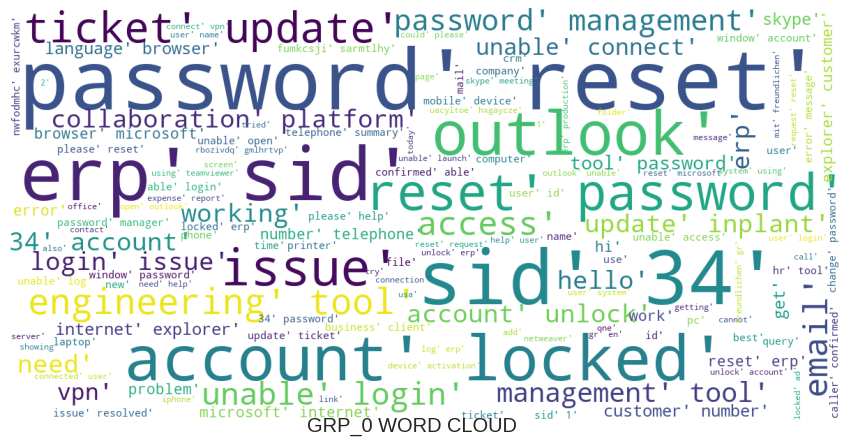

In [89]:
text_Str = ticket_df['desc_lemma'][ticket_df_grp0['Assignment group'].isin(["GRP_0"])].tolist()
show_wordcloud(text_Str, "GRP_0 WORD CLOUD")

In [90]:
X=ticket_df['desc_lemma']
y=ticket_df['Assignment group']

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [92]:
le = LabelEncoder() 
le.fit(pd.concat([y_train,y_test]))

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [93]:
def identity_tokenizer(text):
    return text
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False,max_features=10759)
tfidf.fit(X_train)
tfidf.fit(X_test)

X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [94]:
def precision_recall_fscore_support_roc_auc(model, y_test,X_test):
  y_pred = model.predict(X_test)

  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
  print("Precision: ",precision)
  print("Recall: ",recall)
  print('F1 score: ',f1_score)

  y_proba = model.predict_proba(X_test)

  print("roc_auc value: ",roc_auc_score(y_test, y_proba, labels = clf.classes_, average='macro', multi_class='ovo'))
  cf_matrix = confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n %s' % (cf_matrix))
  plt.subplots(figsize=(25,10))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12}, cmap='Oranges')

In [95]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('train acc: ',clf.score(X_train,y_train))
print('test acc: ',clf.score(X_test, y_test))

train acc:  0.7029366830758784
test acc:  0.6318289786223278


In [102]:
clfGBM = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
print('train acc: ',clfGBM.score(X_train,y_train))
print('test acc: ',clfGBM.score(X_test, y_test))

train acc:  0.594126633848243
test acc:  0.5471100554235946


Precision:  0.6318289786223278
Recall:  0.6318289786223278
F1 score:  0.6318289786223278
roc_auc value:  0.8647639973809499
Confusion matrix:
 [[1167    0    0 ...    0    0    0]
 [   2    0    0 ...    2    0    0]
 [  16    0   15 ...    7    0    0]
 ...
 [   3    0    2 ...  169    1    0]
 [  16    0    0 ...   18   40    0]
 [  13    0    0 ...    1    0    0]]


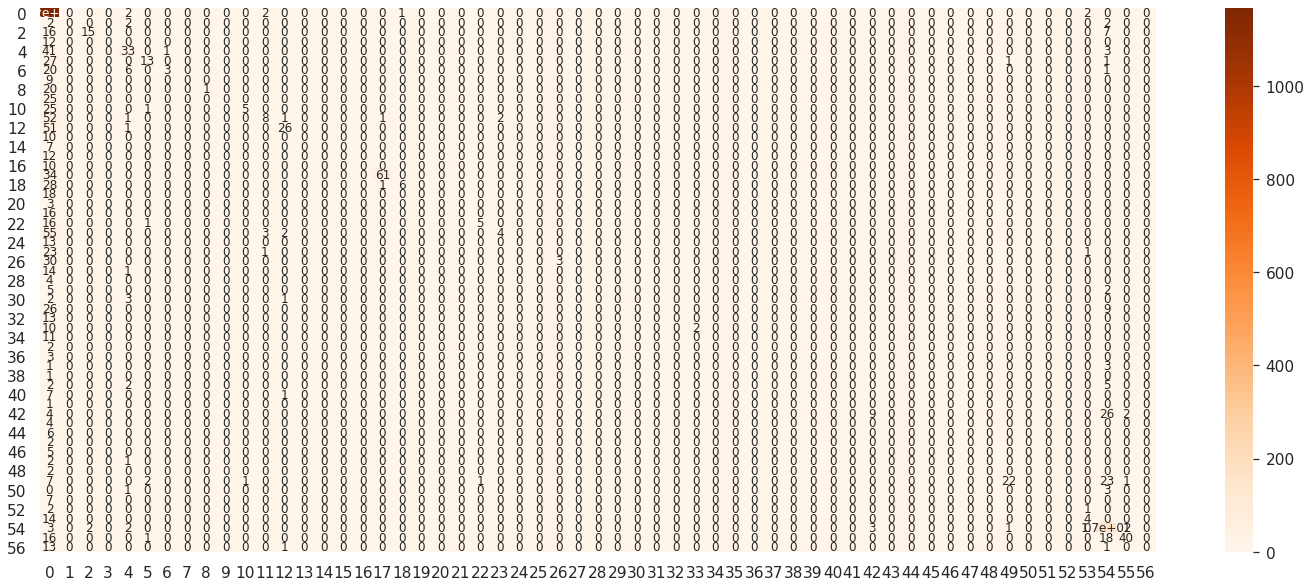

In [97]:
precision_recall_fscore_support_roc_auc(clf,y_test,X_test)

Precision:  0.5471100554235946
Recall:  0.5471100554235946
F1 score:  0.5471100554235946
roc_auc value:  0.546464505297233
Confusion matrix:
 [[1090    0    1 ...    0    0    0]
 [   2    0    0 ...    0    0    0]
 [  15    0    0 ...    6    1    1]
 ...
 [  15    0    0 ...   96    6    0]
 [  17    0    0 ...   45    4    0]
 [  10    1    0 ...    1    0    1]]


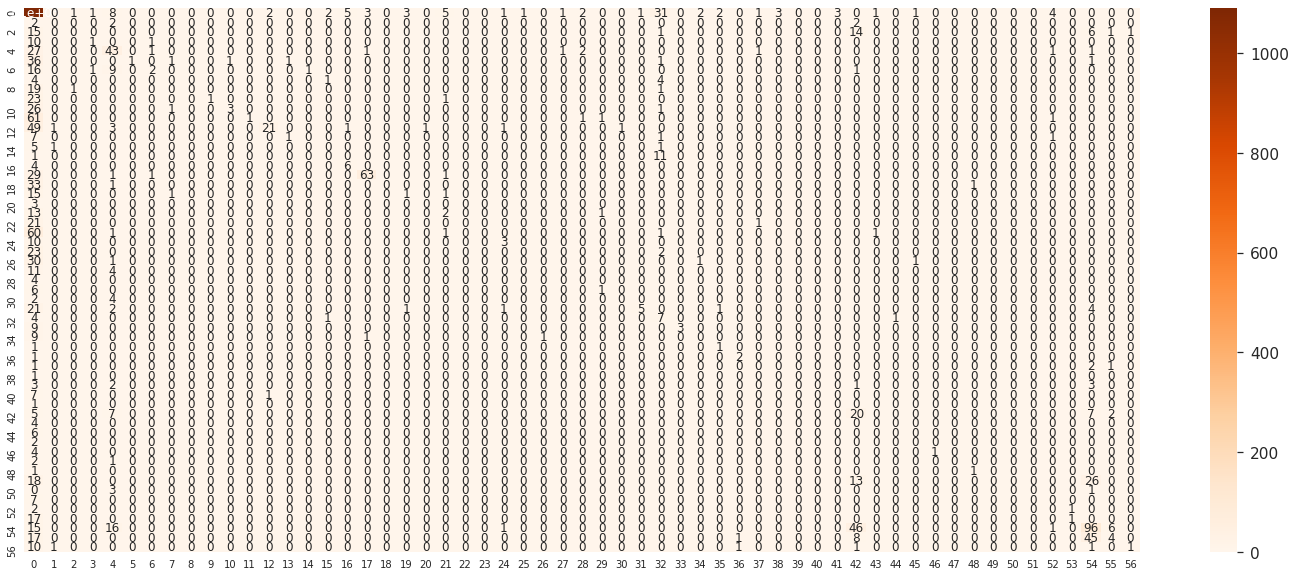

In [103]:
precision_recall_fscore_support_roc_auc(clfGBM,y_test,X_test)